# Sakizuke (Aggressive Inside Course) Analysis

Definition used here:
- Usually `艇番` == `コース`.
- If `コース` is smaller than `艇番`, treat it as "sakizuke" (moving inside).

This notebook quantifies how often sakizuke happens and how it relates to finish position.


In [1]:
from pathlib import Path
import pandas as pd

cwd = Path.cwd()
repo_root = cwd if (cwd / 'data').exists() else cwd.parent.parent

year = '2026'
month = '01'
day = None  # set to '15' for a single day

preview_dir = repo_root / 'data' / 'previews' / year / month
result_dir = repo_root / 'data' / 'results' / year / month

if day:
    preview_paths = [preview_dir / f'{day}.csv']
else:
    preview_paths = sorted(preview_dir.glob('*.csv'))

preview_paths[:3], len(preview_paths)


([PosixPath('/Users/mahiguch/dev/boatrace/data/data/previews/2026/01/01.csv'),
  PosixPath('/Users/mahiguch/dev/boatrace/data/data/previews/2026/01/02.csv'),
  PosixPath('/Users/mahiguch/dev/boatrace/data/data/previews/2026/01/03.csv')],
 17)

In [2]:
previews = []
results = []

for path in preview_paths:
    if not path.exists():
        continue
    preview = pd.read_csv(path)
    preview['source_file'] = path.name
    previews.append(preview)

    result_path = result_dir / path.name
    if result_path.exists():
        result = pd.read_csv(result_path)
        result['source_file'] = result_path.name
        results.append(result)

preview = pd.concat(previews, ignore_index=True)
results = pd.concat(results, ignore_index=True) if results else pd.DataFrame()

preview.shape, results.shape


((2174, 54), (2762, 101))

In [3]:
race_cols = ['レースコード', 'レース日', 'レース場', 'レース回']
boat_features = ['艇番', 'コース']

boat_frames = []
for b in range(1, 7):
    rename = {f'艇{b}_{col}': col for col in boat_features}
    cols = race_cols + list(rename.keys())
    cols = [c for c in cols if c in preview.columns]
    tmp = preview[cols].rename(columns=rename)
    tmp['艇'] = b
    boat_frames.append(tmp)

preview_long = pd.concat(boat_frames, ignore_index=True)
preview_long.head()


,レースコード,レース日,レース場,レース回,艇番,コース,艇
0,202601010601,2026-01-01,6,01R,1,1.0,1
1,202601010602,2026-01-01,6,02R,1,1.0,1
2,202601010603,2026-01-01,6,03R,1,1.0,1
3,202601010604,2026-01-01,6,04R,1,1.0,1
4,202601010605,2026-01-01,6,05R,1,1.0,1


In [4]:
result_frames = []
for order in range(1, 7):
    boat_col = f'{order}着_艇番'
    if boat_col in results.columns:
        tmp = results[['レースコード', boat_col]].copy()
        tmp = tmp.rename(columns={boat_col: '艇番'})
        tmp['着順'] = order
        result_frames.append(tmp)

result_long = pd.concat(result_frames, ignore_index=True) if result_frames else pd.DataFrame()
result_long = result_long.dropna(subset=['艇番']) if not result_long.empty else result_long
result_long.head()


,レースコード,艇番,着順
0,202601012301,3.0,1
1,202601012302,2.0,1
2,202601012304,3.0,1
3,202601012305,6.0,1
4,202601012306,1.0,1


In [5]:
merged = preview_long.merge(result_long, on=['レースコード', '艇番'], how='left')
merged['艇番'] = pd.to_numeric(merged['艇番'], errors='coerce')
merged['コース'] = pd.to_numeric(merged['コース'], errors='coerce')

merged = merged.dropna(subset=['艇番', 'コース'])

merged['course_delta'] = merged['コース'] - merged['艇番']
merged['sakizuke'] = merged['course_delta'] < 0
merged['moved_out'] = merged['course_delta'] > 0

merged[['艇番', 'コース', 'course_delta', 'sakizuke']].head()


,艇番,コース,course_delta,sakizuke
0,1,1.0,0.0,False
1,1,1.0,0.0,False
2,1,1.0,0.0,False
3,1,1.0,0.0,False
4,1,1.0,0.0,False


In [6]:
merged['course_delta'].value_counts().sort_index()


course_delta
-4.0       22
-3.0       33
-2.0       62
-1.0      339
 0.0    11098
 1.0      344
 2.0       66
 3.0       17
 4.0        9
 5.0        2
Name: count, dtype: int64

In [7]:
sakizuke_rate = (
    merged.groupby('艇番')['sakizuke']
    .mean()
    .sort_index()
)
sakizuke_rate


艇番
1    0.000000
2    0.007011
3    0.023000
4    0.030030
5    0.060561
6    0.107393
Name: sakizuke, dtype: float64

In [8]:
if '着順' in merged.columns:
    merged['win'] = merged['着順'] == 1
    merged['top2'] = merged['着順'] <= 2
    merged['top3'] = merged['着順'] <= 3

    sakizuke_perf = (
        merged.groupby('sakizuke')
        .agg(
            count=('着順', 'size'),
            win_rate=('win', 'mean'),
            top2_rate=('top2', 'mean'),
            top3_rate=('top3', 'mean'),
            avg_finish=('着順', 'mean'),
        )
        .sort_index()
    )
    sakizuke_perf
else:
    'Results not available for these previews.'


In [9]:
if '着順' in merged.columns:
    delta_perf = (
        merged.groupby('course_delta')
        .agg(
            count=('着順', 'size'),
            win_rate=('win', 'mean'),
            avg_finish=('着順', 'mean'),
        )
        .sort_index()
    )
    delta_perf
else:
    'Results not available for these previews.'


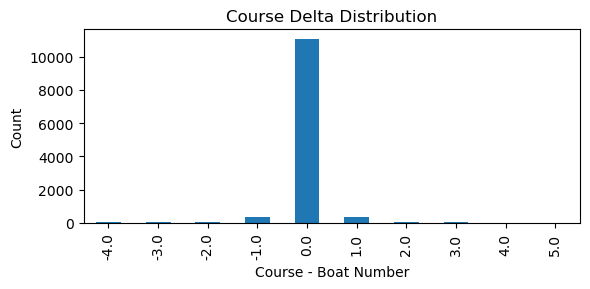

In [10]:
import matplotlib.pyplot as plt

delta_counts = merged['course_delta'].value_counts().sort_index()
ax = delta_counts.plot(kind='bar', figsize=(6, 3), title='Course Delta Distribution')
ax.set_xlabel('Course - Boat Number')
ax.set_ylabel('Count')
plt.tight_layout()


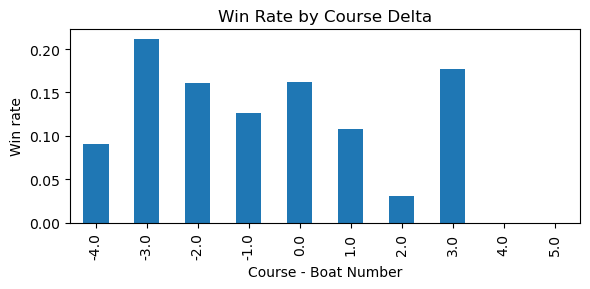

In [11]:
if '着順' in merged.columns:
    ax = (
        delta_perf['win_rate']
        .fillna(0)
        .plot(kind='bar', figsize=(6, 3), title='Win Rate by Course Delta')
    )
    ax.set_xlabel('Course - Boat Number')
    ax.set_ylabel('Win rate')
    plt.tight_layout()
else:
    'Results not available for these previews.'


Next ideas:
- Segment by venue or race class if you add those columns.
- Compare sakizuke rates by race number (1R-12R).
- Add wind/condition features to see if sakizuke increases under specific conditions.
